# Automatic detection of motion artefacts in the ECG signal from a wearable sensor using methods of artificial intelligence
## Master's thesis

In [297]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Reshape, BatchNormalization, concatenate
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.optimizers import Adam
from keras.regularizers import l2, l1
from keras.callbacks import LearningRateScheduler

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

## Helper functions

In [120]:
'''
    Function used to plot training and validation progress
'''
def plot_metrics(history, metric):
    train = history.history[metric]
    val = history.history['val_' + str(metric)]

    plt.figure(figsize=(10, 5))
    
    plt.plot(train, label='Training ' + str(metric), color='blue')
    plt.plot(val, label='Validation ' + str(metric), color='red')
    
    plt.title('Training and validation ' + str(metric))
    plt.xlabel('Epoch')
    plt.ylabel(str(metric).capitalize())
    
    plt.legend()
    plt.show()

In [121]:
'''
    Function used to plot confusion matrix for multi class classification
'''
def plot_confusion_matrix(y_test, y_pred, class_labels):
    conf_mat = confusion_matrix(np.array(y_test), np.array(y_pred))

    # Normalize confusion matrix to show percentages
    conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(conf_mat_norm, 
                annot=True, 
                fmt='.2%', 
                cmap='Blues', 
                xticklabels=class_labels, 
                yticklabels=class_labels,
                ax=ax
               )
    
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix (Normalized)')
    
    plt.show()
    
    return fig

## Dataset creation
- Traverse the data directory to create data file - label file pairs
- Go through all of the pairs and construct the output dataframe - extract corresponding segment from signal and include artefact and activity type labels

In [125]:
PARENT_DIR = '../../data'

ACTIVITIES_NUM = 5               # Number of activity type classes
ARTEFACT_NUM = 4                 # Number of artefact type classes

SEG_LEN_SEC = 2
FS = 500

SEG_LEN = FS * SEG_LEN_SEC 

FFT_LEN = 200

In [127]:
'''
    Create data-label file pairs from the parent path
'''
def create_data_label_pairs():
    data_label_pairs = {}

    # Traverse all ID directories to get the data-label file pairs
    for id_dir in os.listdir(PARENT_DIR):
        data_dir = os.path.join(PARENT_DIR, id_dir)

        # Check if the path is a directory
        if os.path.isdir(data_dir):
            labels_dir = os.path.join(data_dir, 'labels')

            # Double check that data and labels subdirectories exist
            if os.path.exists(data_dir) and os.path.exists(labels_dir):

                # Iterate over .csv files in data directory
                for data_file in os.listdir(data_dir):
                    if data_file.endswith('.csv'):

                        # Check if corresponding label file exists
                        label_file_name = data_file.split('.')[0] + '_' + str(SEG_LEN_SEC) + '.csv'

                        label_path = os.path.join(labels_dir, label_file_name)
                        data_path = os.path.join(data_dir, data_file)

                        if os.path.exists(data_path) and os.path.exists(label_path):
                            data_label_pairs[data_path] = label_path
                            
    return data_label_pairs

data_label_pairs = create_data_label_pairs()

In [128]:
'''
    Create dataframe from data-label file pairs
'''
def create_dataframe(data_label_pairs):
    df = pd.DataFrame(columns = ['artefact_label', 'activity_label'])
    data = []

    # Iterate over matched data-label pairs
    for data_file, label_file in data_label_pairs.items():
        
        df_data = pd.read_csv(data_file, delimiter=';', names=['timestamp', 'value'])
        df_labels = pd.read_csv(label_file, delimiter=';')

        # Iterate over rows in label file
        for idx, row in df_labels.iterrows():
            
            # Extract segment from data based on start and end indices
            start_idx, end_idx = row['start'], row['end']
            segment = df_data.iloc[start_idx:end_idx]['value'].values

            segment = pd.DataFrame(segment, columns=['segment']).T

            # Add activity_type and artefact_type columns
            segment['activity'] = row['activity']
            segment['artefact'] = row['artifact']

            data.append(segment)

    return pd.concat(data, ignore_index=True)

df = create_dataframe(data_label_pairs)
df

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,activity,artefact
0,2134,2125,2130,2131,2137,2136,2143,2141,2149,2155,...,2066,2060,2055,2053,2054,2046,2042,2043,0,1
1,2042,2041,2042,2039,2036,2034,2033,2029,2026,2028,...,2108,2117,2127,2133,2147,2145,2149,2150,0,1
2,2148,2149,2150,2154,2154,2157,2161,2165,2164,2153,...,2090,2097,2103,2107,2114,2121,2119,2117,0,1
3,2120,2125,2121,2125,2125,2124,2124,2119,2108,2104,...,2270,2272,2273,2275,2275,2277,2278,2281,0,1
4,2280,2278,2280,2282,2278,2280,2272,2271,2272,2272,...,2140,2151,2167,2180,2200,2207,2214,2218,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651,2612,2614,2591,2535,2445,2311,2143,1956,1744,1522,...,2101,2115,2128,2138,2142,2136,2107,2059,3,2
3652,2022,1983,1965,1945,1935,1932,1938,1944,1948,1960,...,2147,2181,2209,2218,2214,2205,2194,2180,3,2
3653,2167,2152,2164,2172,2178,2190,2211,2232,2245,2268,...,2027,2031,2015,1973,1915,1828,1710,1577,3,2
3654,1427,1256,1067,875,691,526,393,260,186,189,...,2673,2643,2591,2555,2534,2518,2503,2490,3,2


## Data preprocessing
- Normalize the data to the range of a 12-bit ADC using min-max normalization
- Create new dataframe containing magnitude spectrum of each ECG segment
- Split the dataset into training and testing set
- One-hot encode data labels, to match the output shape of the model

In [129]:
target_columns = ['activity', 'artefact']
min_val, max_val = 0, 4096

# Min-max normalized data
normalized = (df.loc[:, ~df.columns.isin(target_columns)] - min_val) / (max_val - min_val)

# Apply min-max normalization to each column
df_norm = df.copy()

df_norm.loc[:, ~df_norm.columns.isin(target_columns)] = normalized
df_norm

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,activity,artefact
0,0.520996,0.518799,0.520020,0.520264,0.521729,0.521484,0.523193,0.522705,0.524658,0.526123,...,0.504395,0.502930,0.501709,0.501221,0.501465,0.499512,0.498535,0.498779,0,1
1,0.498535,0.498291,0.498535,0.497803,0.497070,0.496582,0.496338,0.495361,0.494629,0.495117,...,0.514648,0.516846,0.519287,0.520752,0.524170,0.523682,0.524658,0.524902,0,1
2,0.524414,0.524658,0.524902,0.525879,0.525879,0.526611,0.527588,0.528564,0.528320,0.525635,...,0.510254,0.511963,0.513428,0.514404,0.516113,0.517822,0.517334,0.516846,0,1
3,0.517578,0.518799,0.517822,0.518799,0.518799,0.518555,0.518555,0.517334,0.514648,0.513672,...,0.554199,0.554688,0.554932,0.555420,0.555420,0.555908,0.556152,0.556885,0,1
4,0.556641,0.556152,0.556641,0.557129,0.556152,0.556641,0.554688,0.554443,0.554688,0.554688,...,0.522461,0.525146,0.529053,0.532227,0.537109,0.538818,0.540527,0.541504,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3651,0.637695,0.638184,0.632568,0.618896,0.596924,0.564209,0.523193,0.477539,0.425781,0.371582,...,0.512939,0.516357,0.519531,0.521973,0.522949,0.521484,0.514404,0.502686,3,2
3652,0.493652,0.484131,0.479736,0.474854,0.472412,0.471680,0.473145,0.474609,0.475586,0.478516,...,0.524170,0.532471,0.539307,0.541504,0.540527,0.538330,0.535645,0.532227,3,2
3653,0.529053,0.525391,0.528320,0.530273,0.531738,0.534668,0.539795,0.544922,0.548096,0.553711,...,0.494873,0.495850,0.491943,0.481689,0.467529,0.446289,0.417480,0.385010,3,2
3654,0.348389,0.306641,0.260498,0.213623,0.168701,0.128418,0.095947,0.063477,0.045410,0.046143,...,0.652588,0.645264,0.632568,0.623779,0.618652,0.614746,0.611084,0.607910,3,2


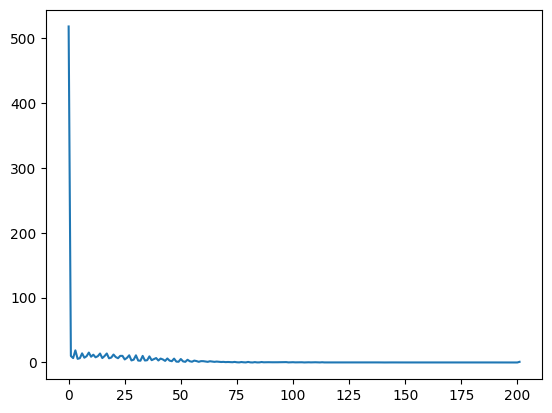

In [130]:
'''
    Create dataframe containing first N points of a spectrum of each ECG segment
'''
def create_fft_dataframe(df, N_freq):    
    ecg_signals = df.iloc[:, :SEG_LEN].values

    # Compute FFT for each ECG signal
    fft_results = np.abs(np.fft.fft(ecg_signals, axis=1))

    # Extract only the first N frequencies
    fft_magnitudes = fft_results[:, :N_freq]

    activity_types = df['activity'].values.reshape(-1, 1)
    artefact_types = df['artefact'].values.reshape(-1, 1)

    df_fft = np.hstack((fft_magnitudes, activity_types, artefact_types))
    df_fft = pd.DataFrame(df_fft, columns=[f'fft_{i}' for i in range(N_freq)] + ['activity', 'artefact'])
    
    return df_fft

    
df_fft = create_fft_dataframe(df_norm, FFT_LEN)

# Plot an example FFT spectrum
plt.plot(df_fft.iloc[0, :1000].values)
plt.show()

In [131]:
df_norm['activity'].value_counts()

1    739
4    737
3    734
0    731
2    715
Name: activity, dtype: int64

In [133]:
# Train test split for ECG signal dataset
X = df_norm.drop(target_columns, axis=1).copy()

y_activity = df_norm['activity'].copy()
y_artefact = df_norm['artefact'].copy()

X_train, X_test, y_train_act, y_test_act = train_test_split(X, y_activity, test_size=0.2, random_state=40)
# _, _, y_train_art, y_test_art = train_test_split(X, y_artefact, test_size=0.2, random_state=40)

X_train

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
3649,0.708496,0.706055,0.700928,0.692627,0.684570,0.676025,0.668213,0.660400,0.656738,0.655029,...,0.146240,0.151611,0.177246,0.224854,0.284912,0.348633,0.412842,0.474854,0.530518,0.578125
271,0.570068,0.570801,0.571045,0.571045,0.572021,0.571045,0.569824,0.568604,0.567383,0.566406,...,0.489502,0.489502,0.488037,0.486816,0.485840,0.485596,0.484131,0.482910,0.481445,0.481445
3371,0.480713,0.477783,0.479736,0.485596,0.494385,0.501953,0.510498,0.516846,0.520752,0.520996,...,0.455322,0.447998,0.444092,0.444092,0.444336,0.442139,0.440186,0.437744,0.435791,0.433105
2755,0.481934,0.480225,0.476318,0.473633,0.469727,0.466797,0.462891,0.460693,0.458008,0.454590,...,0.524658,0.524658,0.525879,0.527344,0.528076,0.527588,0.526123,0.525635,0.524170,0.523193
1324,0.492432,0.489990,0.488281,0.486572,0.484131,0.483643,0.479980,0.479004,0.477783,0.477783,...,0.520752,0.521484,0.523438,0.523926,0.524170,0.525391,0.526367,0.528564,0.529541,0.529541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064,0.526123,0.535889,0.541992,0.548828,0.553711,0.558594,0.561523,0.564697,0.569092,0.572998,...,0.545898,0.545166,0.544434,0.544678,0.543945,0.542969,0.540771,0.538330,0.537842,0.538330
2213,0.651855,0.640625,0.621338,0.591553,0.546387,0.490234,0.423096,0.351562,0.278809,0.215332,...,0.474854,0.473389,0.474365,0.478027,0.482666,0.489746,0.495117,0.501221,0.506836,0.507080
2055,0.447266,0.446777,0.446289,0.445068,0.445312,0.445312,0.445068,0.447754,0.452393,0.456787,...,0.671875,0.656250,0.643066,0.629150,0.617920,0.606934,0.598145,0.590576,0.584229,0.579346
2267,0.447998,0.424805,0.396484,0.357666,0.311523,0.261719,0.211182,0.168213,0.135498,0.119629,...,0.522217,0.521484,0.520752,0.520020,0.521240,0.520752,0.521240,0.522217,0.521240,0.520752


In [132]:
# Train test split for FFT frequencies dataset
X = df_fft.drop(target_columns, axis=1).copy()

X_train_fft, X_test_fft, _, _ = train_test_split(X, y_activity, test_size=0.2, random_state=40)
# X_train_fft, X_test_fft, _, _ = train_test_split(X, y_activity, test_size=0.2, random_state=40)

X_train_fft

,fft_0,fft_1,fft_2,fft_3,fft_4,fft_5,fft_6,fft_7,fft_8,fft_9,...,fft_190,fft_191,fft_192,fft_193,fft_194,fft_195,fft_196,fft_197,fft_198,fft_199
3649,496.122070,11.965366,16.912659,14.170353,13.134198,9.028233,7.582849,10.329976,6.367701,13.553335,...,0.083782,0.104614,0.057597,0.137494,0.143298,0.079382,0.067121,0.089329,0.075937,0.117741
271,513.106689,30.781102,9.337888,4.684532,1.464311,1.245555,11.115374,7.459495,4.938339,11.713525,...,0.090815,0.099483,0.065958,0.064130,0.104864,0.056723,0.069536,0.078012,0.062830,0.059752
3371,505.246826,11.403565,5.020610,10.889551,4.821211,3.638123,12.223704,1.659197,0.268676,11.783430,...,0.054540,0.054014,0.029019,0.016369,0.025069,0.050252,0.042998,0.023319,0.050992,0.050768
2755,503.487549,10.155754,3.722939,11.454771,2.507652,3.404822,8.044049,5.448564,3.842985,6.211823,...,0.042798,0.027740,0.022872,0.034956,0.032762,0.032676,0.060925,0.039940,0.036938,0.059606
1324,505.596680,3.569689,2.478700,9.918006,4.064059,4.407394,6.858414,5.814869,3.838720,9.488441,...,0.050200,0.008784,0.035368,0.027361,0.053899,0.014820,0.017987,0.049193,0.036201,0.044260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064,517.396973,4.824678,9.497301,21.065662,8.389201,9.342189,20.858836,17.330547,9.926181,11.393822,...,0.057790,0.026602,0.085314,0.041801,0.014017,0.061928,0.017626,0.016697,0.048120,0.015555
2213,476.584717,36.436349,20.493362,4.586104,24.229563,8.407203,3.581757,13.241667,0.355622,7.478767,...,0.144977,0.153357,0.128716,0.147587,0.115234,0.114384,0.147019,0.102885,0.082526,0.111757
2055,504.524414,12.671225,12.592199,37.627682,9.679966,13.894162,4.683088,0.875796,5.374586,18.032393,...,0.141304,0.160324,0.115634,0.152863,0.107481,0.113084,0.021460,0.168403,0.078494,0.084615
2267,498.809082,8.239820,6.629782,14.363396,6.085944,3.395483,5.513833,6.050441,12.735822,9.219186,...,0.074396,0.079083,0.023674,0.051768,0.033714,0.113801,0.032105,0.066939,0.011467,0.047726


In [134]:
# One-hot encoding
y_train_act_enc = tf.keras.utils.to_categorical(y_train_act, num_classes=ACTIVITIES_NUM)

# y_train_art_enc = tf.keras.utils.to_categorical(y_train_art, num_classes=ARTEFACT_NUM)

## Model architectures
Possible parameter options:
- __Epochs:__ Tried up to 100, the convergence is very slow to none after about 20-30 epochs
- __Batch size and learning rate:__ The combination of lr = 0.001 and batch_size = 16 seems to be the best one, tried batch sizes from 8 to 512, learning rates from 0.00001 to 0.01
- __Loss:__ Categorical cross-entropy, Kullback-Leibler divergence behaviour in this case possibly the same as cross-entropy
- __Output activation:__ Softmax, nothing else makes much sense
- __Input activation:__ ReLU, should help with vanishing gradient

Efforts to stabilize training and reduce overfitting:
- __Dropout:__ Tried different rates, placed dropout layers after each dense layer, worsened performance
- __Batch normalization:__ Placed batch normalization layers after each dense layer, worsened performance
- __L2 Regularization:__ Tried using L2 regularization for all dense layers, worsened performance
- __Weight decay:__ Tried using L2 regularization as weight decay in optimizer
- __Learning rate scheduling:__ Slightly improved performance


In [263]:
params = {
    'epochs': 20,
    'batch_size': 16,
    'learning_rate': 0.001, 
    'dropout': 0.3,
    'optimizer': 'Adam',
    'hidden_activation': 'relu',
    'output_activation': 'softmax',
    'loss': 'categorical_crossentropy',
    'metric': 'accuracy',
    'weight_decay': 0
}

In [227]:
'''
    Custom learning rate schedule function, reduces learning rate based on epoch number
'''
def lr_schedule(epoch):
    initial_lr = params['learning_rate']
    
    # Use initial learning rate for the first 10 epochs
    if epoch < 10:
        return initial_lr  
    # Modify the learning rate by a factor after 10 epochs
    else:
        return initial_lr * 0.2
    
lr_scheduler = LearningRateScheduler(lr_schedule)

In [214]:
'''
    Activity type classification model, ECG input together with FFT
'''
def activity_classifier(ecg_len, fft_len, num_activities):
    # Input layer for ECG segments
    ecg_input = Input(shape=(ecg_len,), name = 'signal_input')
    
    # Input layer for FFT segments
    fft_input = Input(shape=(fft_len,), name = 'frequency_input')
    
    concatenated = concatenate([ecg_input, fft_input])
    
    # Fully connected and dropout layers
    dense1 = Dense(1024, activation = params['hidden_activation'])(concatenated)
#     dropout1 = Dropout(params['dropout'])(dense1) 

    dense2 = Dense(512, activation = params['hidden_activation'])(dense1)
#     dropout2 = Dropout(params['dropout'])(dense2) 
#     batch_norm2 = BatchNormalization()(dense2)
    
    dense3 = Dense(256, activation = params['hidden_activation'])(dense2)
#     dropout3 = Dropout(params['dropout'])(dense3)  
#     batch_norm3 = BatchNormalization()(dense3)
    
    dense4 = Dense(128, activation = params['hidden_activation'])(dense3)
#     dropout4 = Dropout(params['dropout'])(dense4)
#     batch_norm4 = BatchNormalization()(dense4)

    dense5 = Dense(64, activation = params['hidden_activation'])(dense4)
    
    # Output layer for activity prediction
    output = Dense(num_activities, activation = params['output_activation'], name = 'output')(dense5)
    
    opt = Adam(weight_decay = params['weight_decay'])
    
    model = Model(inputs = [ecg_input, fft_input], outputs = output)
    
    model.compile(optimizer = opt, loss = params['loss'], metrics = params['metric'])
    
    return model


model = activity_classifier(SEG_LEN, FFT_LEN, ACTIVITIES_NUM)
model.summary()

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 signal_input (InputLayer)   [(None, 1000)]               0         []                            
                                                                                                  
 frequency_input (InputLaye  [(None, 200)]                0         []                            
 r)                                                                                               
                                                                                                  
 concatenate_48 (Concatenat  (None, 1200)                 0         ['signal_input[0][0]',        
 e)                                                                  'frequency_input[0][0]']     
                                                                                           

In [301]:
'''
    Activity type classification convolutional model, ECG input together with FFT
'''
def activity_classifier_conv(ecg_len, fft_len, num_activities):
    # Input layer for ECG segments
    ecg_input = Input(shape=(ecg_len,), name='signal_input')
    
    # Input layer for FFT segments
    fft_input = Input(shape=(fft_len,), name='frequency_input')
    
    # Fully connected and dropout layers for ECG signal
    ecg_dense1 = Dense(1024, activation=params['hidden_activation'])(ecg_input)
    ecg_dense2 = Dense(512, activation=params['hidden_activation'])(ecg_dense1)
    
    # Reshape FFT input for convolutional layer
    fft_reshaped = Reshape((fft_len, 1))(fft_input)
    
    # Convolutional layers for FFT
    conv1 = Conv1D(32, kernel_size=5, activation='relu')(fft_reshaped)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    
    conv2 = Conv1D(64, kernel_size=5, activation='relu')(pool1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    flatten_fft = Flatten()(pool2)
    
    # Concatenate outputs from dense and convolutional paths
    concatenated = concatenate([ecg_dense1, flatten_fft])
    
    # Fully connected layers
#     dense3 = Dense(256, activation=params['hidden_activation'])(concatenated)
    dense4 = Dense(128, activation=params['hidden_activation'])(concatenated)
    dropout4 = Dropout(params['dropout'])(dense4)  
    
    dense5 = Dense(64, activation=params['hidden_activation'])(dropout4)
    
    # Output layer for activity prediction
    output = Dense(num_activities, activation=params['output_activation'], name='output')(dense5)
    
    # Optimizer with weight decay
    opt = Adam(weight_decay=params['weight_decay'])
    
    model = Model(inputs=[ecg_input, fft_input], outputs=output)
    
    model.compile(optimizer=opt, loss=params['loss'], metrics=[params['metric']])
    
    return model

model = activity_classifier_conv(SEG_LEN, FFT_LEN, ACTIVITIES_NUM)
model.summary()

Model: "model_73"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 frequency_input (InputLaye  [(None, 200)]                0         []                            
 r)                                                                                               
                                                                                                  
 reshape_37 (Reshape)        (None, 200, 1)               0         ['frequency_input[0][0]']     
                                                                                                  
 conv1d_77 (Conv1D)          (None, 196, 32)              192       ['reshape_37[0][0]']          
                                                                                                  
 max_pooling1d_75 (MaxPooli  (None, 98, 32)               0         ['conv1d_77[0][0]']    

## Training

In [302]:
# Init Neptune.ai project
run = neptune.init_run(
    project = 'veronika.kalouskova/DP-Activity-Classification',
    api_token = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMTY5NGI5ZS0xNzk1LTQwYjItYjc0Ny1lZWNmZjdjZjg1MzEifQ==',
)

# Log model parameters into Neptune
run['parameters'] = params

# Log model summary and architecture into Neptune
neptune_callback = NeptuneCallback(run=run)

history = model.fit([X_train, X_train_fft],
                    y_train_act_enc, 
                    epochs = params['epochs'], 
                    batch_size = params['batch_size'], 
                    validation_split=0.1,
                    callbacks=[neptune_callback, lr_scheduler]
                   )

# Log model architecture and weights into Neptune
model.save('models/model.keras')

run['saved_model'].upload('models/model.keras')


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/veronika.kalouskova/DP-Activity-Classification/e/DUM-138
Epoch 1/20
165/165 [==============================] - 4s 15ms/step - loss: 1.5312 - accuracy: 0.3197 - val_loss: 1.2326 - val_accuracy: 0.4915 - lr: 0.0010
Epoch 2/20
165/165 [==============================] - 2s 13ms/step - loss: 1.2287 - accuracy: 0.4576 - val_loss: 1.1590 - val_accuracy: 0.5461 - lr: 0.0010
Epoch 3/20
165/165 [==============================] - 2s 14ms/step - loss: 1.1300 - accuracy: 0.5101 - val_loss: 1.0454 - val_accuracy: 0.5666 - lr: 0.0010
Epoch 4/20
165/165 [==============================] - 2s 14ms/step - loss: 1.0273 - accuracy: 0.5656 - val_loss: 0.8907 - val_accuracy: 0.6621 - lr: 0.0010
Epoch 5/20
165/165 [==============================] - 2s 14ms/step - loss: 0.9188 - accuracy: 0.6188 - val_loss: 0.8384 - val_accuracy: 0.6792 - lr: 0.0010
Epoch 6/20
165/165 [==============================] - 2s 14ms/step - loss: 0.8439 

## Evaluation

23/23 [==============================] - 0s 3ms/step


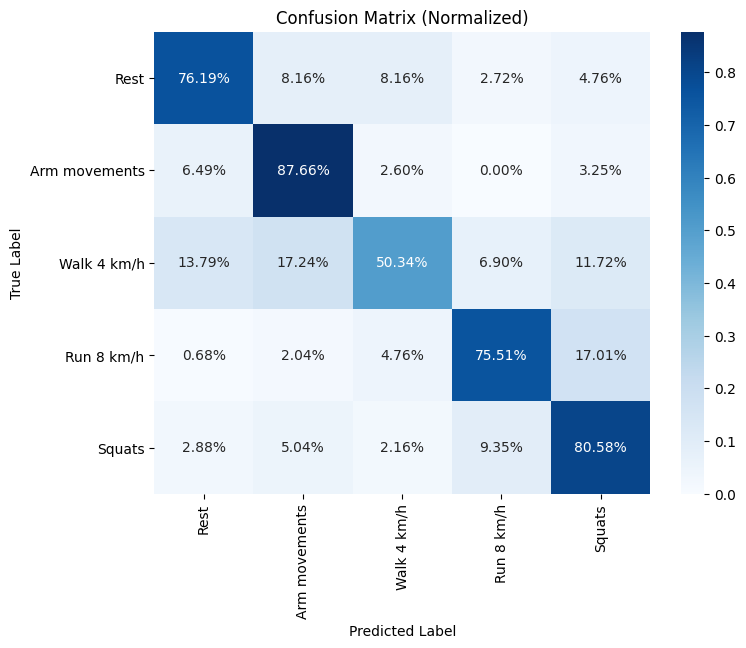

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/veronika.kalouskova/DP-Activity-Classification/e/DUM-137/metadata


In [300]:
preds_act = model.predict([X_test, X_test_fft])
y_pred_act = np.argmax(preds_act, axis=1)

accuracy = accuracy_score(y_test_act, y_pred_act)
run["eval/accuracy"] = accuracy

class_labels = ['Rest', 'Arm movements', 'Walk 4 km/h', 'Run 8 km/h', 'Squats']

fig = plot_confusion_matrix(y_test_act, y_pred_act, class_labels)
run["eval/confusion_matrix"] = fig

run.stop()

In [267]:
plot_metrics(history, 'loss')
plot_metrics(history, 'accuracy')

KeyError: 'val_loss'